In [1]:
import numpy as np 
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt # matplotlib for plotting
import re # regular expressions
import warnings
warnings.filterwarnings("ignore") #because who likes annoying warnings

plt.style.use('ggplot') #prettier pictures

import datetime      #for datetime operations
import calendar      #for calendar for datetime operations
import time          #to get the system time
plt.rcParams['figure.figsize'] = [16, 10] #set default figure size

from sklearn.model_selection import train_test_split
from sklearn.linear_model  import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score
import xgboost as xgb


In [2]:
df = pd.read_csv('../data/clean_train.csv')

# Data Preparation for Modelling

Since we have a variety of data types within the dataset, we must wrangle them accordingly to get them ready for modelling.

- Get rid of irrelevant columns such as "id"
- Only use log_trip_duration instead of both the former and trip_duration (can't have pretty much the same variable as a predictor variable
- Use one hot encoding (pandas get_dummies) for the categorical variables such as "vendor_id", "passenger_count", various date columns (day, week, month), and cluster labels
- Randomly split the data, assign predictor and target variables and train!


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1436572 entries, 0 to 1436571
Data columns (total 26 columns):
Unnamed: 0                  1436572 non-null int64
id                          1436572 non-null object
vendor_id                   1436572 non-null int64
pickup_datetime             1436572 non-null object
dropoff_datetime            1436572 non-null object
passenger_count             1436572 non-null int64
pickup_longitude            1436572 non-null float64
pickup_latitude             1436572 non-null float64
dropoff_longitude           1436572 non-null float64
dropoff_latitude            1436572 non-null float64
store_and_fwd_flag          1436572 non-null int64
trip_duration               1436572 non-null int64
date                        1436572 non-null object
minimum temperature         1436572 non-null int64
precipitation               1436572 non-null float64
snow fall                   1436572 non-null float64
snow depth                  1436572 non-null float64
lo

In [4]:
#dropping id because it's irrelevant, dropping log_trip_duration so we can append to the end when we are ready

df = df.drop(['id','log_trip_duration'], 1) 

In [5]:
vendor_train = pd.get_dummies(df['vendor_id'], prefix='vi', prefix_sep='_')
passenger_count_train = pd.get_dummies(df['passenger_count'], prefix='pc', prefix_sep='_')
store_and_fwd_flag_train = pd.get_dummies(df['store_and_fwd_flag'], prefix='sf', prefix_sep='_')
cluster_pickup_train = pd.get_dummies(df['pickup_cluster'], prefix='p', prefix_sep='_')
cluster_dropoff_train = pd.get_dummies(df['dropoff_cluster'], prefix='d', prefix_sep='_')
month_train = pd.get_dummies(df['Month'], prefix='m', prefix_sep='_')
hour_train = pd.get_dummies(df['Hour'], prefix='h', prefix_sep='_')
dow_train = pd.get_dummies(df['dayofweek'], prefix='dow', prefix_sep='_')

In [6]:
#drop the encoded variables, drop dropoff_datetime (because this is just counterintuitive to what we want to guess)
#and since there is not gonna be such a variable in the test set. 

#we could technically drop pickup & dropoff long/lat since it is somewhat generally encoded in the cluster label variables.

df = df.drop(['vendor_id','passenger_count','store_and_fwd_flag','Month','Hour','dayofweek', 'distance_dummy_manhattan',
             'pickup_longitude','pickup_latitude','dropoff_longitude','dropoff_latitude','dropoff_datetime'],axis = 1)

In [7]:
df_final = pd.concat([df,
                          vendor_train,
                          passenger_count_train,
                          store_and_fwd_flag_train,
                          cluster_pickup_train,
                          cluster_dropoff_train,
                          month_train,
                          hour_train,
                          dow_train
                         ], axis=1)

In [8]:
df_final['log_trip_duration'] = np.log(df['trip_duration'].values + 1)

In [9]:
#drop pickup_datetime and date, since it is in the dummy variables now. drop newly formed id and unamed 0 columns
#drop trip duration
#drop pickup and dropoff clusters since they are encoded within dummy variables

df_final = df_final.drop(['trip_duration', 'pickup_datetime', 'date', 
                          'Unnamed: 0', 'pickup_cluster', 'dropoff_cluster'], 1)

In [10]:
df_final.shape

(1436572, 86)

# Linear Regression log_trip_prediction

In [11]:
#seperating into predictor and target variables

X = df_final.drop('log_trip_duration', 1) #every column except for log_trip_duration
y = df_final['log_trip_duration'] #target variable

In [12]:
#random splitting 
#set random state for deterministic random probabilities
X_train, X_test, y_train, y_test = train_test_split(X, y , test_size = 0.2, random_state = 42)

In [13]:
model = LinearRegression()
model.fit(X_train,y_train)
y_pred = model.predict(X_test)

In [14]:
print("R^2: {}".format(model.score(X_test, y_test)))
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print("Root Mean Log Squared Error: {}".format(rmse))

R^2: 0.5415465972593874
Root Mean Log Squared Error: 0.5185110017503476


Looking at the Root Mean Log Squared Error, it is still rather high at approximately 0.5185. Hopefully we can get that down using some other modelling methods.

In [15]:
cv_scores = cross_val_score(model, X, y, cv= 5)
print(cv_scores)
print("Average 5-Fold CV Score: {}".format(np.mean(cv_scores)))

[0.5387179  0.53663454 0.54098088 0.53994324 0.53896503]
Average 5-Fold CV Score: 0.5390483159438688


In [16]:
col_names = list(X.columns)
coef = list(model.coef_.astype(float))

In [17]:
show_coef = pd.DataFrame(
    {'Attributes': col_names,
     'Coefficients': coef})
show_coef.sort_values(by = 'Coefficients', ascending = False).head(10)

,Attributes,Coefficients
8,vi_2,7.826021e+07
7,vi_1,7.826021e+07
81,dow_3,5.734294e+07
80,dow_2,5.734294e+07
82,dow_4,5.734294e+07
79,dow_1,5.734294e+07
83,dow_5,5.734294e+07
78,dow_0,5.734294e+07
84,dow_6,5.734294e+07
26,p_8,4.071119e+06


The highest positive valued coefficients of the linear regression model is the vendor ids, and several of the dropoff cluster labels.

In [29]:
show_coef.sort_values(by = 'Coefficients', ascending = False).tail(10)

,Attributes,Coefficients
15,pc_6,-7.651517e+06
14,pc_5,-7.651517e+06
10,pc_1,-7.651517e+06
9,pc_0,-7.651519e+06
53,m_6,-3.054051e+08
52,m_5,-3.054051e+08
51,m_4,-3.054051e+08
50,m_3,-3.054051e+08
49,m_2,-3.054051e+08
48,m_1,-3.054051e+08


Similarly, on the other end of the spectrum, the most negative valued coefficients of the linear regression model were some of the passenger count dummy variables, followed by the month dummy variables.

# XGBoost Predicting log_trip_duration

In [18]:
#using the same split of predictor and target variables as before.
data_dmatrix = xgb.DMatrix(data=X,label=y)

In [19]:
dtrain = xgb.DMatrix(X_train, label=y_train)
dvalid = xgb.DMatrix(X_test, label=y_test)
watchlist = [(dtrain, 'train'), (dvalid, 'valid')]

In [20]:
#selecting parameteres for XGBoost algorithm. Will run until there is no improvement in 
#RMSE in 10 rounds
#uncomment and run (takes a long while though)



#md = [6]
#lr = [0.1, 0.3]
#mcw = [20,25,30]
#for m in md:
#    for l in lr:
#        for n in mcw:
#            xgb_pars = {'min_child_weight': n, 'eta': l, 'colsample_bytree': 0.9, 
#                        'max_depth': m, 'subsample': 0.9, 'lambda': 1., 'nthread': -1, 
#                        'booster' : 'gbtree', 'silent': 1, 'eval_metric': 'rmse', 'objective': 'reg:linear'}
#            model = xgb.train(xgb_pars, dtrain, 50, watchlist, early_stopping_rounds=10, maximize=False, verbose_eval=1)

In [22]:
xgb_pars = {'min_child_weight': 1, 'eta': 0.3, 'colsample_bytree': 0.9, 
            'max_depth': 7, 'subsample': 0.9, 'lambda': 1., 'nthread': -1,
            'booster' : 'gbtree', 'silent': 1, 'eval_metric': 'rmse', 'objective': 'reg:linear'}
model = xgb.train(xgb_pars, dtrain, 20, watchlist, early_stopping_rounds=2, maximize=False, verbose_eval=1)
print('Modeling RMSLE %.5f' % model.best_score)

[0]	train-rmse:4.21124	valid-rmse:4.21162
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 2 rounds.
[1]	train-rmse:2.96461	valid-rmse:2.96482
[2]	train-rmse:2.09832	valid-rmse:2.09849
[3]	train-rmse:1.50041	valid-rmse:1.50043
[4]	train-rmse:1.09363	valid-rmse:1.09362
[5]	train-rmse:0.822409	valid-rmse:0.82236
[6]	train-rmse:0.648375	valid-rmse:0.648299
[7]	train-rmse:0.541825	valid-rmse:0.541714
[8]	train-rmse:0.478316	valid-rmse:0.478233
[9]	train-rmse:0.442395	valid-rmse:0.44239
[10]	train-rmse:0.422669	valid-rmse:0.422674
[11]	train-rmse:0.411192	valid-rmse:0.411129
[12]	train-rmse:0.402609	valid-rmse:0.402614
[13]	train-rmse:0.397606	valid-rmse:0.397821
[14]	train-rmse:0.39415	valid-rmse:0.394486
[15]	train-rmse:0.39092	valid-rmse:0.391286
[16]	train-rmse:0.388608	valid-rmse:0.389039
[17]	train-rmse:0.386758	valid-rmse:0.387339
[18]	train-rmse:0.385137	valid-rmse:0.385821
[19]	train-rmse:0.383545	

By using the set of parameters in xgb_pars, we see that XGBoost model was able to get the Root Mean Log Squared Error of the test set down to 0.384, a considerable improvement from the simple linear regression model. We can see that the model performs as well as it did on the training set as it did on the test set. 

We could theoretically take this to the "clean_test.csv" and apply the same data wrangling transformations to the data set to predict the ride duration. However, this would be non-sensical, since this project is not for a kaggle submission, and the clean_test.csv data set does not contain a ride duration or trip duration field that we can check our predictions against. 

[08:12:07] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[08:12:08] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[08:12:09] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[08:12:11] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[08:12:12] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[08:12:13] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[08:12:14] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[08:12:15] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[08:12:16] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_

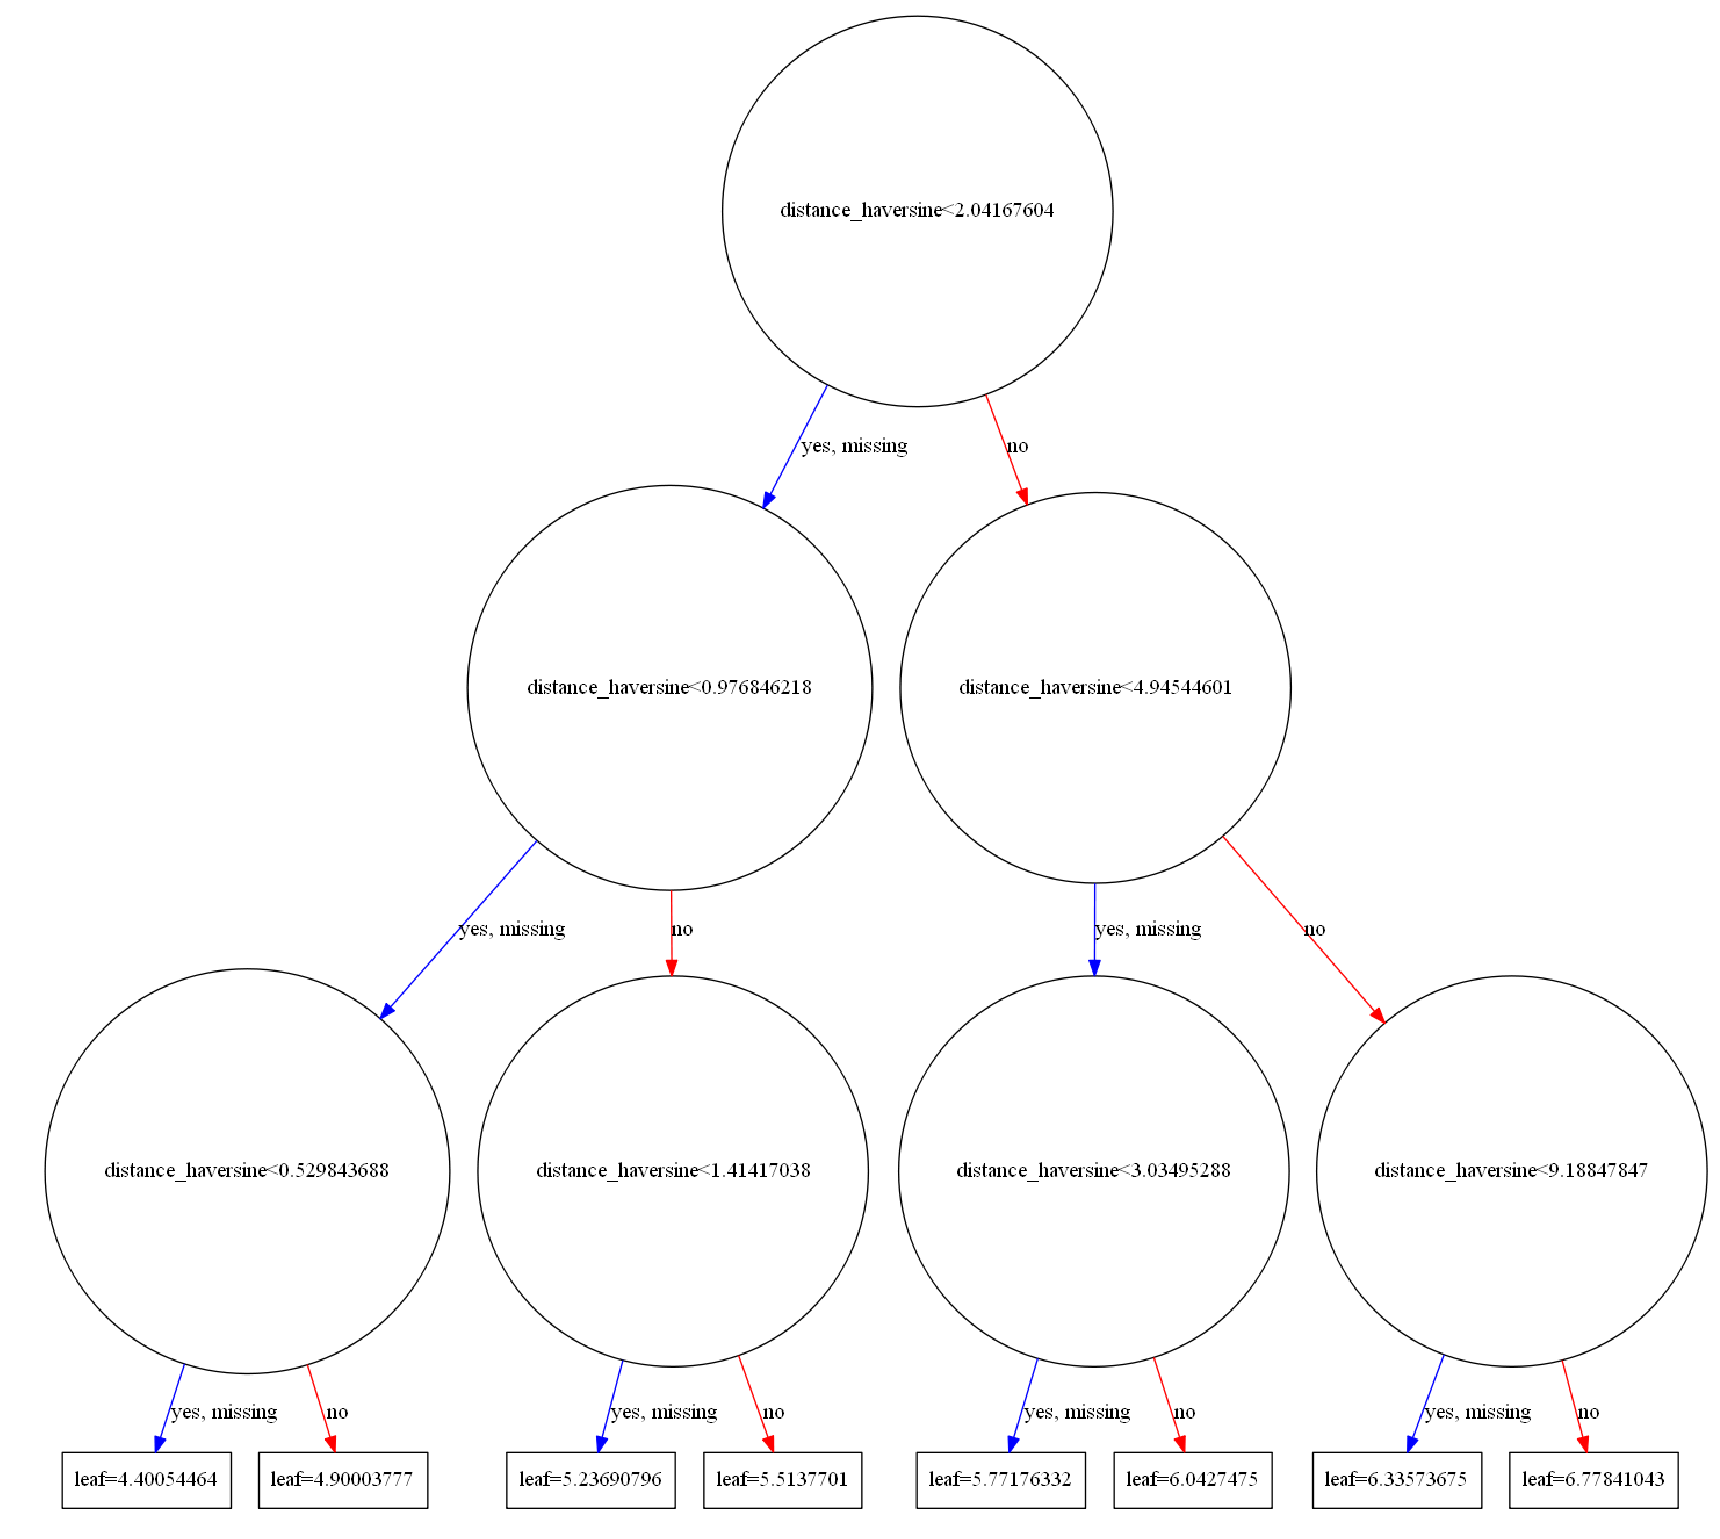

In [26]:
#use  max_depth 3 so that we can a good visual representation of the initial splits of the trees
params = {"objective":"reg:linear",'colsample_bytree': 0.3,'learning_rate': 0.95,
                'max_depth': 3, 'alpha': 10}

xg_reg = xgb.train(params=params, dtrain=data_dmatrix, num_boost_round=10)
xgb.plot_tree(xg_reg,num_trees=0)
plt.rcParams['figure.figsize'] = [100, 100]
plt.show()

As an example, we plot a single tree from our model, and define the max depth to be 3 so that we can get a less pixelated illustrations of how our model splits on each leaf. The entirerity of this single tree is getting split upon the distance_haversine metric, and we see how it arrives at the conclusion of the log_trip_duration in the end.

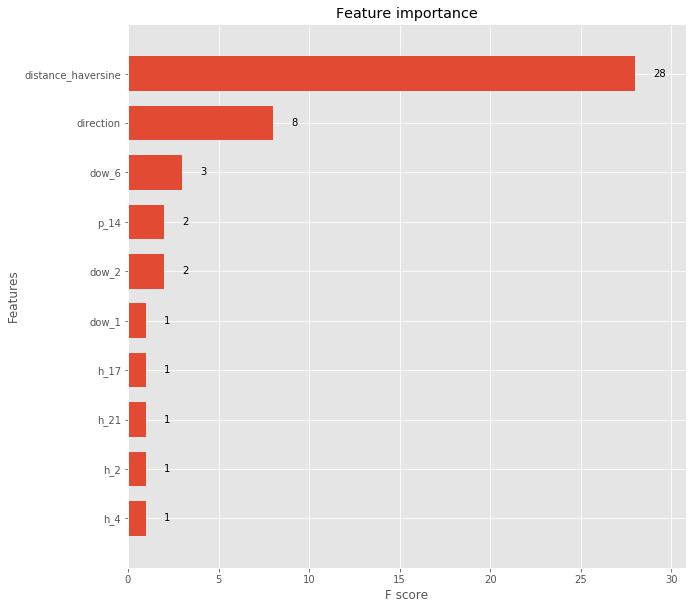

In [28]:
xgb.plot_importance(xg_reg, max_num_features=10, height=0.7)
plt.rcParams['figure.figsize'] = [10, 10]
plt.show()

The feature importance plot above shows which features have the greatest effect on trip duration. It shows the number of times each feature is split on across all boosting rounds in the model, illustrated as a horizontal bar plot. Since there were 88 features, it would be difficult to see all of the feature importances, so the above plot shows the top 10 features (arbitrarily determined number).

Furthermore, we see that direction, distance, day of week variables,  and pickup cluster variables are the biggest factors in determining trip duration for taxis in NYC.